#### SVC on [parkinsons data](https://archive.ics.uci.edu/ml/datasets/Parkinsons)
* improved prediction accuracy through
    * data normalization
    * dimensionality reduction: PCA, isomap
    * tuning parameters

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

In [2]:
# load the data
flc = '/Users/pinqingkan/Desktop/DataScience/PythonDataScience/DAT210x-master/Module6/Datasets/'
fname = flc + 'parkinsons.data'
X = pd.read_csv(fname, index_col = 0)

In [3]:
# split into data & labels
Y = X.status
X = X.drop(labels = ['status'], axis = 1)

In [4]:
# split the datasets into training & testing data
# random_state = 7 to ensure repeatable results; skiped in real cases
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 7)

In [5]:
# SVC classifier without any specification
svc = SVC(cache_size = 200)
svc.fit(X_train, Y_train)
print('score: ', svc.score(X_test, Y_test))

score:  0.813559322034


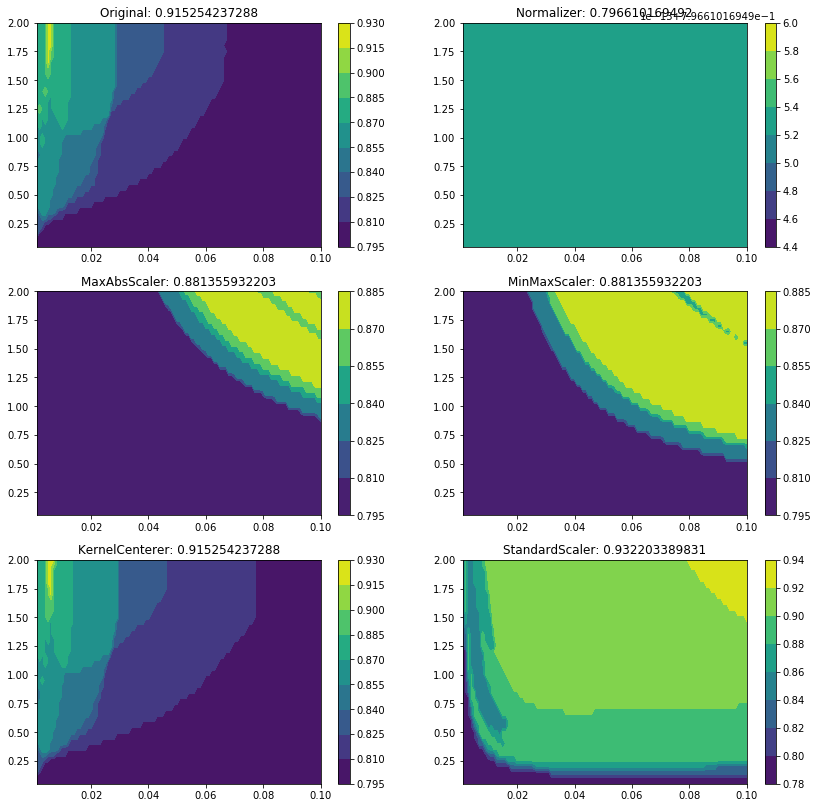

In [6]:
plt.figure(figsize = (14,14))

# test different parameters for SVC-rbf
Cs = np.arange(0.05, 2.05, 0.05)
nC = len(Cs)
gammas = np.arange(1e-3, .101, 1e-3)
ngamma = len(gammas)
xx, yy = np.meshgrid(gammas, Cs)

# test different normalization
for inorm in range(6):
    if inorm > 0:
        if inorm == 1:
            norm = prep.Normalizer()
            fttl = 'Normalizer'
        elif inorm == 2:
            norm = prep.MaxAbsScaler()
            fttl = 'MaxAbsScaler'
        elif inorm == 3:
            norm = prep.MinMaxScaler()
            fttl = 'MinMaxScaler'
        elif inorm == 4:
            norm = prep.KernelCenterer()
            fttl = 'KernelCenterer'
        elif inorm == 5:
            norm = prep.StandardScaler()
            fttl = 'StandardScaler'
        norm = norm.fit(X_train)
        X_train0 = norm.transform(X_train)
        X_test0 = norm.transform(X_test)
    else:
        X_train0, X_test0 = X_train, X_test
        fttl = 'Original'
    
    # SVC for each C, gamma values
    scores = np.zeros( (nC, ngamma) )
    for iC in Cs:
        col, = np.where(Cs == iC)
        for igamma in gammas:
            row, = np.where(gammas == igamma)
            svc = SVC(C = iC, gamma = igamma, cache_size = 200)
            svc.fit(X_train0, Y_train)
            scores[col, row] = svc.score(X_test0, Y_test)
    
    plt.subplot(3,2,inorm+1)
    fig = plt.contourf(xx, yy, scores)
    plt.colorbar(fig)
    fttl0 = fttl + ': ' + str(np.max(scores))
    plt.title(fttl0)
plt.show()

In [7]:
# need to normalize the data!
norm = prep.StandardScaler().fit(X_train)
X_train0, X_test0 = norm.transform(X_train), norm.transform(X_test)

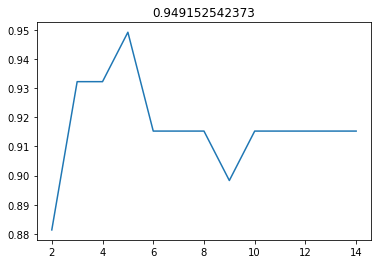

In [8]:
# test if PCA helps
PCs = np.arange(2,15,1)
nPC = len(PCs)
scores = np.zeros(nPC)
for iPC in range(nPC):
    pca = PCA(n_components = PCs[iPC], svd_solver = 'full')
    pca.fit(X_train0)
    Z_train = pca.transform(X_train0)
    Z_test = pca.transform(X_test0)
    # SVC
    svc = SVC(cache_size = 200)
    svc.fit(Z_train, Y_train)
    scores[iPC] = svc.score(Z_test, Y_test)
plt.figure()
plt.plot(PCs, scores)
plt.title(np.max(scores))
plt.show()

In [9]:
row, = np.where(scores == np.max(scores))
print('No. components: ', PCs[row])

No. components:  [5]


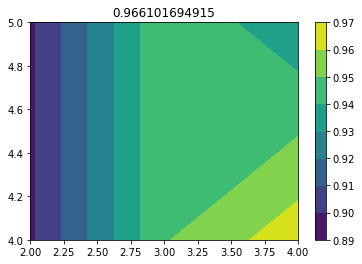

In [10]:
# test if isomap helps
Cmps = np.arange(4,6,1)#Cmps = [4]#
Nghs = np.arange(2,5,1)#Nghs = [4]#
nCmp, nNgh = len(Cmps), len(Nghs)
scores = np.zeros((nCmp, nNgh))
xx, yy = np.meshgrid(Nghs, Cmps)
for icmp in range(nCmp):
    for ingh in range(nNgh):
        iso = Isomap(n_neighbors = Nghs[ingh], n_components = Cmps[icmp],
                     eigen_solver = 'auto', max_iter = None, neighbors_algorithm = 'auto',
                     path_method = 'auto', tol = 0)
        iso.fit(X_train0)
        W_train = iso.transform(X_train0)
        W_test = iso.transform(X_test0)
        # SVC
        svc = SVC(cache_size = 200, C = 1, gamma = .25)
        svc.fit(W_train, Y_train)
        scores[icmp,ingh] = svc.score(W_test, Y_test)
plt.figure()
fig = plt.contourf(xx, yy, scores)
plt.colorbar(fig)
plt.title(np.max(scores))
plt.show()

In [11]:
row, col = np.where(scores == np.max(scores))
print('No. components: ', Cmps[row])
print('No. neighbors: ', Nghs[col])

No. components:  [4]
No. neighbors:  [4]


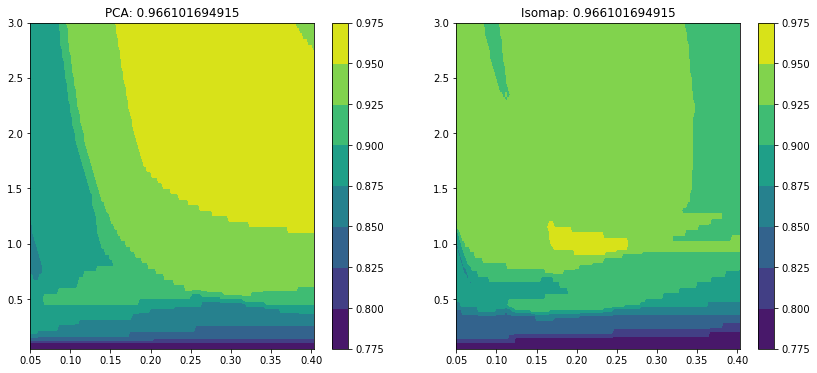

In [12]:
# try combine all improvements together:
# PCA: 5 components / isomap: 4 components, 4 neighbors
# standardscaler normalization
# C ~ 1, gamma ~ 0.25

# normalize
norm = prep.StandardScaler().fit(X_train)
X_train0, X_test0 = norm.transform(X_train), norm.transform(X_test)

# extend the range of parameters
#Cs = np.arange(0.05, 2.05, 0.05)
#gammas = np.arange(1e-3, .101, 1e-3)
Cs = np.arange(0.05, 3.05, 0.05)
nC = len(Cs)
gammas = np.arange(.05, .405, 2e-3)
ngamma = len(gammas)
xx, yy = np.meshgrid(gammas, Cs)

plt.figure(figsize = (14,6))

for icase in range(2):
    if icase == 0: # PCA
        model = PCA(n_components = 5, svd_solver = 'full')
        fttl = 'PCA'
    elif icase == 1: # isomap
        model = Isomap(n_neighbors = 4, n_components = 4,
                     eigen_solver = 'auto', max_iter = None, neighbors_algorithm = 'auto',
                     path_method = 'auto', tol = 0)
        fttl = 'Isomap'
    model.fit(X_train0)
    Z_train = model.transform(X_train0)
    Z_test = model.transform(X_test0)

    scores = np.zeros( (nC, ngamma) )
    for iC in Cs:
        col, = np.where(Cs == iC)
        for igamma in gammas:
            row, = np.where(gammas == igamma)
            svc = SVC(C = iC, gamma = igamma, cache_size = 200)
            svc.fit(Z_train, Y_train)
            scores[col, row] = svc.score(Z_test, Y_test)
            #print(svc.score(Z_test, Y_test))
            
    plt.subplot(1,2,icase+1)
    fig = plt.contourf(xx, yy, scores)
    plt.colorbar(fig)
    fttl0 = fttl + ': ' + str(np.max(scores))
    plt.title(fttl0)
plt.show()